<span style="font-size:1.1em;">Colab'a Google drive'ı entegre ediyoruz. Kullanılacak olan veriseti Google Drive'da bulunmaktadır</span>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import pandas as pd 

<span style="font-size:1.1em;">Google Drive'ımızın root pathi</span> ```gdrive/My Drive``` <span style="font-size:1.1em;">oluyor. Proje için gerekli verisetini **mbti** adında bir klasör oluşturup içerisine yüklüyoruz. İlgili verisetinin pathi</span> ```gdrive/My Drive/mbti/all_users.csv``` <span style="font-size:1.1em;">oluyor.</span>

In [0]:
df = pd.read_csv("gdrive/My Drive/mbti/all_users_v2.csv", sep = ';', header = 0) 

In [0]:
df

,user,entry,type,typeClass,I/E,S/N,T/F,J/P
0,19991991,ekşi itiraf sonunda döndüm dolaştım geldim ken...,ENTJ,analysts,E,N,T,J
1,19991991,selda bağcan bu sesi canlı dinleyebilmek benim...,ENTJ,analysts,E,N,T,J
2,19991991,eski sevgilisinin mutlu olmasını isteyen insan...,ENTJ,analysts,E,N,T,J
3,19991991,veda ederken 2019'a bir not bırakmak farklı ac...,ENTJ,analysts,E,N,T,J
4,19991991,ingiliz aksanı bu aralar özellikle bayıldığım ...,ENTJ,analysts,E,N,T,J
...,...,...,...,...,...,...,...,...
643907,zaimoglu,zlatan ibrahimoviç türkiye de katil olur,ESFJ,sentinels,E,S,F,J
643908,zaimoglu,tarihteki en büyük yalancılar şike operasyonu ...,ESFJ,sentinels,E,S,F,J
643909,zaimoglu,akp-chp koalisyonu hayali koalisyondur,ESFJ,sentinels,E,S,F,J
643910,zaimoglu,trabzonlu insana hamsi diyen fenerbahçe taraft...,ESFJ,sentinels,E,S,F,J


In [0]:
import matplotlib.pyplot as plt

<span style="font-size:1.1em;">Verisetinin **class** tiplerine göre dağılım</span>

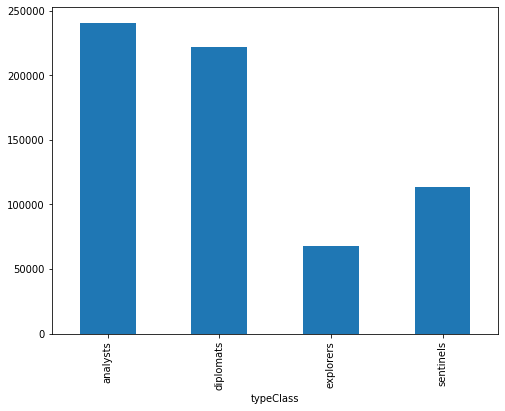

In [0]:
fig = plt.figure(figsize=(8,6))

df.groupby('typeClass').type.count().plot.bar(ylim=0)
plt.savefig('dataset_distribution_typeClass.png')
plt.show()

<span style="font-size:1.1em;">Verisetindeki **I/E** dağılımını göstermektedir. I olanlar x ekseninde 0 olarak E olanlar ise 1 olarak gösterilmektedir</span>

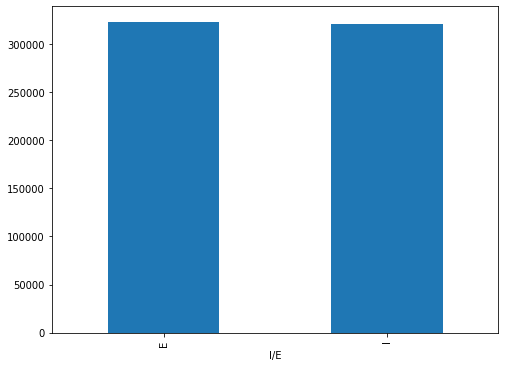

In [0]:
fig = plt.figure(figsize=(8,6))

df.groupby('I/E').type.count().plot.bar(ylim=0)
plt.savefig('gdrive/My Drive/mbti/dataset_distribution_I-E.png')
plt.show()

<span style="font-size:1.1em;">Verisetindeki **S/N** dağılımını göstermektedir. N olanlar x ekseninde 0 olarak S olanlar ise 1 olarak gösterilmektedir</span>

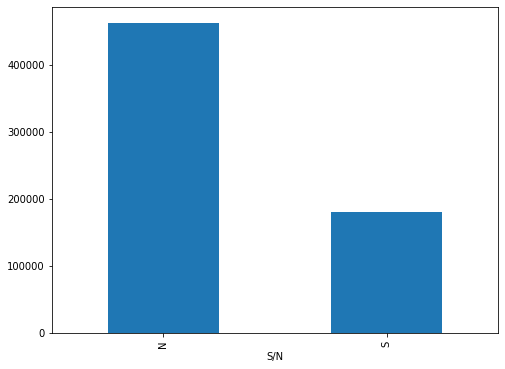

In [0]:
fig = plt.figure(figsize=(8,6))

df.groupby('S/N').type.count().plot.bar(ylim=0)
plt.savefig('gdrive/My Drive/mbtidataset_distribution_S-N.png')
plt.show()

<span style="font-size:1.1em;">Verisetindeki **T/F** dağılımını göstermektedir. F olanlar x ekseninde 0 olarak T olanlar ise 1 olarak gösterilmektedir</span>

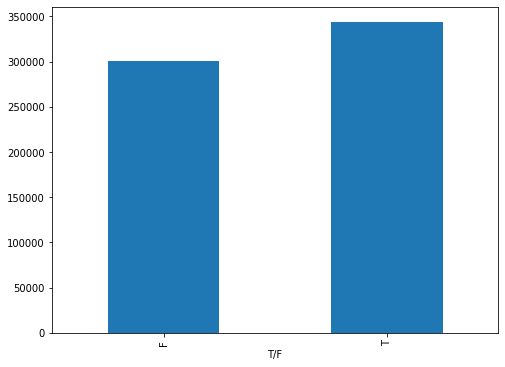

In [0]:
fig = plt.figure(figsize=(8,6))

df.groupby('T/F').type.count().plot.bar(ylim=0)
plt.savefig('gdrive/My Drive/mbti/dataset_distribution_T-F.png')
plt.show()

<span style="font-size:1.1em;">Verisetindeki **J/P** dağılımını göstermektedir. P olanlar x ekseninde 0 olarak J olanlar ise 1 olarak gösterilmektedir</span>

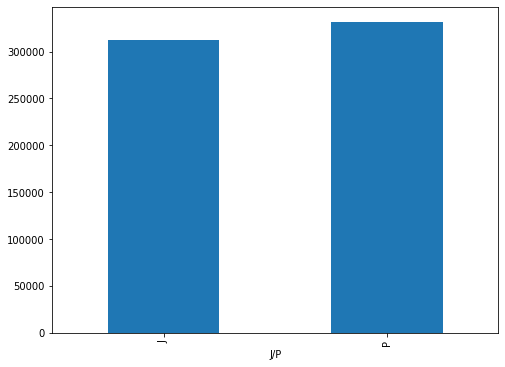

In [0]:
fig = plt.figure(figsize=(8,6))

df.groupby('J/P').type.count().plot.bar(ylim=0)
plt.savefig('gdrive/My Drive/mbti/dataset_distribution_J-P.png')
plt.show()

Aşağıda ise verisetinin 16 farklı MBTI kişilik tiplerine göre dağılımı gösterilmektedir.

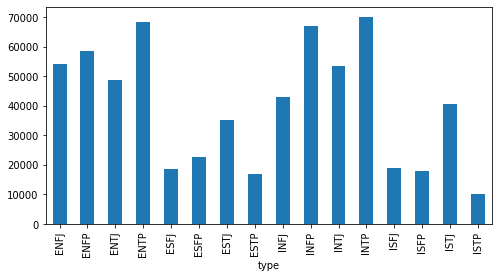

In [0]:
fig = plt.figure(figsize=(8,4))

df.groupby('type').type.count().plot.bar(ylim=0)
plt.savefig('gdrive/My Drive/mbti/dataset_distribution_type.png')
plt.show()

Stop words, drive'da /mbti altındaki stop_words_tr.txt okunarak alınır

---



In [0]:
file = open("gdrive/My Drive/mbti/stop_words_tr.txt")
stop_word_list = file.read().split('\n')
file.close()

In [0]:
stop_word_list

['Hm',
 'Hmm',
 'Osmanlıca',
 'Rabbena',
 'Türkçesi',
 'a',
 'aa',
 'aaa',
 'aaah',
 'aah',
 'abe',
 'abes',
 'abo',
 'abosa',
 'abov',
 'abow',
 'abu',
 'acaba',
 'acayip',
 'accelerando',
 'acele',
 'aceleten',
 'acep',
 'acilen',
 'acımasız',
 'acımasızcasına',
 'adamakıllı',
 'adamcasına',
 'adedî',
 'adeta',
 'adilane',
 'adına',
 'afedersin',
 'afedersinin',
 'aferin',
 'affettuoso',
 'agitato',
 'agucuk',
 'ah',
 'aha',
 'ahacık',
 'ahbap',
 'aheste',
 'ahir',
 'ahiren',
 'ahlaken',
 'ailecek',
 'ait',
 'akabinde',
 'akilane',
 'aklen',
 'aklınca',
 'aksine',
 'akıbet',
 'akşamdan',
 'akşamları',
 'akşamleyin',
 'akşamüstü',
 'akşamüzeri',
 'alabildiğine',
 'alarga',
 'alelacele',
 'alelhesap',
 'alelhusus',
 'alelumum',
 'alelusul',
 'alelıtlak',
 'alenen',
 'alessabah',
 'aleykümselâm',
 'alicenap',
 'alimallah',
 'allahtan',
 'allegretto',
 'allegro',
 'alo',
 'altmış',
 'altı',
 'altıncı',
 'altışar',
 'ama',
 'amabile',
 'aman',
 'amanın',
 'amca',
 'amenna',
 'amirane',
 '

# Pre-Processing

Entrylere ön işleme adımları uygulanır. Bu adımlar:


1.   Bütün harflerin küçük harf haline getirilmesi

2.   '**bkz**', '**--- spoiler ---**', '**spoiler**', '**#12341324**' (gibi böyle rakamların devam ettiği) entrylerin verisetinden çıkarılması gerekmektedir.

3. Entrylerden stop words'ler silinmelidir.

4. Web sitelerinin temizlenmesi

5. Noktalama işaretlerinin temizlenmesi

6. Rakamların temizlenmesi

7. Stemming kullanılması

Temizlenme işlemlerinde empty string yerine space (' ') ile replace edilerek yapılmalıdır. Arından da fazla boşluklar vs trim edilmelidir.

```[+-]?([0-9]*)([.][0-9])?``` regex olarak kullanılacak hem rakamların silinmesinde hem de ondaklı sayıların silinmesinde --> buna gerek kalmadı


Entrylerdeki harfler küçük harf haline getirilir

In [0]:
df['entry'] = df['entry'].str.lower()

Dataframe içerisindeki bütün entrylere '**bkz**', '**spoiler**', '**#**' içerip içermediğine bakar ve bunun sonucu index numarasıyla birlikte döner. ```15 True``` gibi bu demek oluyor ki 15 numaralı index bizim yazmış olduğumuz koşulu sağlamaktadır.

In [0]:
indexes_contains_unwanted_words = df['entry'].str.contains('|'.join(['bkz', 'spoiler', r'#\d*']))

Dataframe'den ilgili entryler çıkartılır

In [0]:
df = df[~indexes_contains_unwanted_words]
df.shape[0]

524840

Entrylerden stop words silinir.   --> Bu kısım gerekmeyebilir


In [0]:
df['entry'] = df['entry'].str.replace('|'.join(stop_word_list), ' ')

KeyboardInterrupt: ignored

Entrylerden web site linkleri silinir.

In [0]:
df['entry'] = df['entry'].str.replace(r'http\S+', ' ', regex=True)
df['entry'] = df['entry'].str.replace(r'www\S+', '', regex=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Entrylerden noktalama işaretleri temizlenir.

In [0]:
import string

df['entry'] = df['entry'].apply(lambda x: x.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation))))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Entrylerden rakamlar silinir.

In [0]:
df['entry'] = df['entry'].str.replace('\d+', ' ')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Verisetinin stemmera sokmadan önceki ön işlemeden geçirilmiş hali kaydedilir. Buradaki amaç stemmerdan geçirilmiş ve geçirilmemiş halinin başarı açısından karşılaştırılmasının yapılabilmesi.

In [0]:
df.to_csv("gdrive/My Drive/mbti/preprocessed_dataset_v1.csv", sep=';', encoding='utf-8')

SnowballStemmer içerisinde Türkçe dili için kullanabileceğimiz TurkishStemmer import edilir. Stemmer ile kelimelerin köklerine ulaşılır. Lemmatization işlemiyle kök bulunduğu zaman elde edilen kökler biçimsel açıdan da doğru olurken (yani mantıksal açıdan da) stemmer ile elde edilen köklerde böyle bir durum söz konusu değildir. Dolayısıyla stemming edilmis hallerine bakıldıgında mantıksal açıdan düzgün sonuclar vermeyebilir.

Google Colab'a snowballstemmer ile ilgil package'i indirmek için aşağıdaki komutu çalıştırıyoruz.

In [0]:
!pip install snowballstemmer

In [0]:
from snowballstemmer import TurkishStemmer

In [0]:
stemmer = TurkishStemmer()

row_count = df.shape[0]
kökler = stemmer.stemWords(entry.split(" "))

for i in range(row_count):
    entry = df['entry'][i]
    entry_kokler = stemmer.stemWords(entry.split(" "))
    df['entry'][i] = " ".join(entry_kokler)
    
df['entry']

0      duygularnı belli etmeye in model bu be şu ara ...
1      ankara en güzel bar ne bil biz iç sürekli gidi...
2      ekşi itiraf vallahi dil kemik yok 50 yaş saç s...
3      500 lira danışmanlık ücret isteye avukat hakkı...
4      star trek enterpris yani atılga gemis ve müret...
                             ...                        
144    zsuat asfalt çöplük heykel ve cansız ma gip şe...
145    zor flüt çaldıra eğit siste flüt dedik alet yu...
146    bira içe türbanlı kız bu kon ilgil basitçe düş...
147    autocadı öğrenmek zor olmama rağme dur lan bir...
148    gitar ye başlayan tavsiye gitar çalmak bisikle...
Name: entry, Length: 149, dtype: object

Stemmera sokulmuş hali kaydedilir.

In [0]:
df.to_csv("gdrive/My Drive/mbti/preprocessed_dataset_v2.csv", sep=';', encoding='utf-8')

TF-IDF özellik vektörünün çıkartılmasında kullanılacak değişken aşağıda belirlenmiş olan parametrelerle oluşturulur.

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, norm='l2', encoding='utf-8', ngram_range=(1, 2), stop_words = stop_word_list, max_features=5000, analyzer = 'word', token_pattern=r'\w{1,}')

**Feature Extraction** 

Burada tf-idf vektörlerinin çıkartılmasında kullanılacak olan vocabulary oluşturulur.

In [0]:
tfidf_vectorizer.fit(df['entry'])

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['lahî'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=5000,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['Hm', 'Hmm', 'Osmanlıca', 'Rabbena', 'Türkçesi',
                            'a', 'aa', 'aaa', 'aaah', 'aah', 'abe', 'abes',
                            'abo', 'abosa', 'abov', 'abow', 'abu', 'acaba',
                            'acayip', 'accelerando', 'acele', 'aceleten',
                            'acep', 'acilen', 'acımasız', 'acımasızcasına',
                            'adamakıllı', 'adamcasına', 'adedî', 'adeta', ...],
                strip_accents=None, sublinear_tf=True, token_pattern='\\w{1,}',
                tokenizer=None, use_idf=True, vocabulary=None)

Veriseti train ve test olmak üzere ikiye ayrılır. Test %20 ve train %80'ini oluşturacak şekilde tüm veriseti bölünür. random_state parametresi ile tekrardan bölündüğünde bir öncekiyle aynı train ve test veri setlerinin oluşturulması sağlanır.

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df['entry'], df['typeClass'], random_state = 42, test_size = 0.20)

Train ve test datasetlerinden tf-idf vektörleri çıkartılır


In [0]:
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

Multinominal Naive Bayes modeli oluşturulur. Oluşturulan bu model verisetinde "type" olarak belirtilen "analysts", "diplomats", "sentimenls", "explorers" sınıflarından hangilerine ait olduğunu tahmin etmek için kullanılır

In [0]:
from sklearn.naive_bayes import MultinomialNB

In [0]:
clf = MultinomialNB().fit(X_train_tfidf, y_train)
test_typeClass = y_test.values

predictions = clf.predict(X_test_tfidf)

In [0]:
predictions

array(['analysts', 'analysts', 'analysts', ..., 'analysts', 'diplomats',
       'analysts'], dtype='<U9')

<span style="font-size:1.1em">Yapılacak tahminlerle ilgili istatistiksel verileri tutmak için</span> ```predictions_result```<span style="font-size:1.1em"> adında bir değişken oluşturulur.</span>

<span style="font-size:1.1em">Bu değişkenin yapısı aşağıdaki gibidir.</span>

```json
{
    "predicted": {
        "analysts":  { "actual": {"analysts": 0, "diplomats": 0, "explorers": 0, "sentinels": 0} }
        "diplomats": { "actual": {"analysts": 0, "diplomats": 0, "explorers": 0, "sentinels": 0} }
        "explorers": { "actual": {"analysts": 0, "diplomats": 0, "explorers": 0, "sentinels": 0} }
        "sentinels": { "actual": {"analysts": 0, "diplomats": 0, "explorers": 0, "sentinels": 0} }
    }
}
```

* <span style="font-size:1.1em;">Yapılan tahminlerle ilgili verilere ulaşabilmek için</span>

    ```predictions_results['predicted']```


* <span style="font-size:1.1em;">Yapılan tahminin analyst ise:</span>

    ```predictions_results['predicted']['analysts']``` 


* <span style="font-size:1.1em;">Yapılan analyst tahmininin gerçek değerlerine erişmek için:</span>     

    ```predictions_results['predicted']['analysts']['actual']```  


* <span style="font-size:1.1em;">Test verisi, model tarafından analysts olarak tahmin edilmiştir ve bu verinin gerçek değeri de analysts'tir.</span>

    ```predictions_results['predicted']['analysts']['actual']['analysts']``` 

In [0]:
prediction_results = {'predicted': {}}  ## prediction_result['analysts'] means prediction is 'analysts'

prediction_results['predicted']['analysts']  = {'actual': {'analysts': 0, 'diplomats': 0, 'explorers': 0, 'sentinels': 0}}
prediction_results['predicted']['diplomats'] = {'actual': {'analysts': 0, 'diplomats': 0, 'explorers': 0, 'sentinels': 0}}
prediction_results['predicted']['explorers'] = {'actual': {'analysts': 0, 'diplomats': 0, 'explorers': 0, 'sentinels': 0}}
prediction_results['predicted']['sentinels'] = {'actual': {'analysts': 0, 'diplomats': 0, 'explorers': 0, 'sentinels': 0}}

## prediction_result['analysts']['diplomats'] means prediction is analysts but actual value is diplomats

```prediction_results```<span style="font-size:1.1em"> içerisinde tutulan sayaçların değerleri arttırılır.</span>

In [0]:
for i in range(len(predictions)):
  predicted_value = predictions[i]
  actual_value = test_typeClass[i]
  prediction_results['predicted'][predicted_value]['actual'][actual_value] += 1

<span style="font-size:1.1em">JSON formatına çevrilir </span>```dict``` <span style="font-size:1.1em">tipi. Bu sayede daha okunaklı bir şekilde print edilmiş olur. </span>

In [0]:
import json

print(json.dumps(prediction_results, indent = 2))

{
  "predicted": {
    "analysts": {
      "actual": {
        "analysts": 38435,
        "diplomats": 28056,
        "explorers": 10084,
        "sentinels": 17542
      }
    },
    "diplomats": {
      "actual": {
        "analysts": 9521,
        "diplomats": 16309,
        "explorers": 3348,
        "sentinels": 5030
      }
    },
    "explorers": {
      "actual": {
        "analysts": 0,
        "diplomats": 1,
        "explorers": 0,
        "sentinels": 2
      }
    },
    "sentinels": {
      "actual": {
        "analysts": 95,
        "diplomats": 123,
        "explorers": 47,
        "sentinels": 190
      }
    }
  }
}


<span style="font-size:1.1em;">İlgili field extract edilir</span> ```dict``` <span style="font-size:1.1em;">yapısından.</span>

In [0]:
results = prediction_results['predicted']

<span style="font-size:1.1em;">Başarı oranı hesaplanır</span>

In [0]:
accuracy = (results['analysts']['actual']['analysts'] + results['diplomats']['actual']['diplomats'] + results['explorers']['actual']['explorers'] + results['sentinels']['actual']['sentinels']) / len(predictions)
accuracy

0.42656251213281254

<span style="font-size:1.1em;">**E/I** boyutu tahmin edilir</span>

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df['entry'], df['I/E'], random_state = 42)  ## Geri kalanlar S, T, J

X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

clf = MultinomialNB().fit(X_train_tfidf, y_train)
test_typeClass = y_test.values

predictions = clf.predict(X_test_tfidf)

In [0]:
predictions

array(['E', 'E', 'E', ..., 'I', 'I', 'I'], dtype='<U1')

In [0]:
predicted = {}
predicted['I'] = {'actual': {'I': 0, 'E': 0}}
predicted['E'] = {'actual': {'I': 0, 'E': 0}}
predicted

{'E': {'actual': {'E': 0, 'I': 0}}, 'I': {'actual': {'E': 0, 'I': 0}}}

In [0]:
for i in range(len(predictions)):
  predicted[predictions[i]]['actual'][test_typeClass[i]] += 1


In [0]:
predicted

{'E': {'actual': {'E': 32427, 'I': 21303}},
 'I': {'actual': {'E': 48381, 'I': 58867}}}

In [0]:
accuracy = (predicted['E']['actual']['E'] + predicted['I']['actual']['I']) / len(predictions)

In [0]:
accuracy

0.5671209730522183

<span style="font-size:1.1em">**S/N** boyutu tahmin edilir.</span>

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df['entry'], df['S/N'], random_state = 42)  ## Geri kalan boyutlar: T, J

X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

clf = MultinomialNB().fit(X_train_tfidf, y_train)
test_typeClass = y_test.values

predictions = clf.predict(X_test_tfidf)

In [0]:
predicted['N'] = {'actual': {'N': 0, 'S': 0}}
predicted['S'] = {'actual': {'N': 0, 'S': 0}}

predicted

{'E': {'actual': {'E': 32427, 'I': 21303}},
 'I': {'actual': {'E': 48381, 'I': 58867}},
 'N': {'actual': {'N': 0, 'S': 0}},
 'S': {'actual': {'N': 0, 'S': 0}}}

In [0]:
for i in range(len(predictions)):
  predicted[predictions[i]]['actual'][test_typeClass[i]] += 1

In [0]:
predicted

{'E': {'actual': {'E': 32427, 'I': 21303}},
 'I': {'actual': {'E': 48381, 'I': 58867}},
 'N': {'actual': {'N': 115527, 'S': 45391}},
 'S': {'actual': {'N': 25, 'S': 35}}}

In [0]:
accuracy = (predicted['N']['actual']['N'] + predicted['S']['actual']['S']) / len(predictions)

In [0]:
accuracy

0.7178744921666315

<span style="font-size:1.1em">**T/F** boyutu tahmin edilir.</span>

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df['entry'], df['T/F'], random_state = 42)  ##  J

X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

clf = MultinomialNB().fit(X_train_tfidf, y_train)
test_typeClass = y_test.values

predictions = clf.predict(X_test_tfidf)

In [0]:
predicted['T'] = {'actual': {'T': 0, 'F': 0}}
predicted['F'] = {'actual': {'T': 0, 'F': 0}}

predicted

{'E': {'actual': {'E': 32427, 'I': 21303}},
 'F': {'actual': {'F': 0, 'T': 0}},
 'I': {'actual': {'E': 48381, 'I': 58867}},
 'N': {'actual': {'N': 115527, 'S': 45391}},
 'S': {'actual': {'N': 25, 'S': 35}},
 'T': {'actual': {'F': 0, 'T': 0}}}

In [0]:
for i in range(len(predictions)):
  predicted[predictions[i]]['actual'][test_typeClass[i]] += 1

In [0]:
predicted

{'E': {'actual': {'E': 32427, 'I': 21303}},
 'F': {'actual': {'F': 23204, 'T': 14732}},
 'I': {'actual': {'E': 48381, 'I': 58867}},
 'N': {'actual': {'N': 115527, 'S': 45391}},
 'S': {'actual': {'N': 25, 'S': 35}},
 'T': {'actual': {'F': 51749, 'T': 71293}}}

In [0]:
accuracy = (predicted['F']['actual']['F'] + predicted['T']['actual']['T']) / len(predictions)

In [0]:
accuracy

0.5870181018524271

<span style="font-size:1.1em">**J/P** boyutu tahmin edilir.</span>

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df['entry'], df['J/P'], random_state = 42) 

X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

clf = MultinomialNB().fit(X_train_tfidf, y_train)
test_typeClass = y_test.values

predictions = clf.predict(X_test_tfidf)

In [0]:
predicted['J'] = {'actual': {'J': 0, 'P': 0}}
predicted['P'] = {'actual': {'J': 0, 'P': 0}}

predicted

{'E': {'actual': {'E': 32427, 'I': 21303}},
 'F': {'actual': {'F': 23204, 'T': 14732}},
 'I': {'actual': {'E': 48381, 'I': 58867}},
 'J': {'actual': {'J': 0, 'P': 0}},
 'N': {'actual': {'N': 115527, 'S': 45391}},
 'P': {'actual': {'J': 0, 'P': 0}},
 'S': {'actual': {'N': 25, 'S': 35}},
 'T': {'actual': {'F': 51749, 'T': 71293}}}

In [0]:
for i in range(len(predictions)):
  predicted[predictions[i]]['actual'][test_typeClass[i]] += 1

In [0]:
predicted

{'E': {'actual': {'E': 32427, 'I': 21303}},
 'F': {'actual': {'F': 23204, 'T': 14732}},
 'I': {'actual': {'E': 48381, 'I': 58867}},
 'J': {'actual': {'J': 37293, 'P': 29220}},
 'N': {'actual': {'N': 115527, 'S': 45391}},
 'P': {'actual': {'J': 40994, 'P': 53471}},
 'S': {'actual': {'N': 25, 'S': 35}},
 'T': {'actual': {'F': 51749, 'T': 71293}}}

In [0]:
accuracy = (predicted['P']['actual']['P'] + predicted['J']['actual']['J']) / len(predictions)

In [0]:
accuracy

0.5638285976965797

In [0]:
prediction_results['predicted'].update(predicted) 

prediction_results

{'predicted': {'E': {'actual': {'E': 32427, 'I': 21303}},
  'F': {'actual': {'F': 23204, 'T': 14732}},
  'I': {'actual': {'E': 48381, 'I': 58867}},
  'J': {'actual': {'J': 37293, 'P': 29220}},
  'N': {'actual': {'N': 115527, 'S': 45391}},
  'P': {'actual': {'J': 40994, 'P': 53471}},
  'S': {'actual': {'N': 25, 'S': 35}},
  'T': {'actual': {'F': 51749, 'T': 71293}},
  'analysts': {'actual': {'analysts': 38435,
    'diplomats': 28056,
    'explorers': 10084,
    'sentinels': 17542}},
  'diplomats': {'actual': {'analysts': 9521,
    'diplomats': 16309,
    'explorers': 3348,
    'sentinels': 5030}},
  'explorers': {'actual': {'analysts': 0,
    'diplomats': 1,
    'explorers': 0,
    'sentinels': 2}},
  'sentinels': {'actual': {'analysts': 95,
    'diplomats': 123,
    'explorers': 47,
    'sentinels': 190}}}}